In [1]:
import sys
sys.path.append("/home/j-gunmo/desktop/00.my-project/17.P-Stage-T1003/4-STAGE/")

from fe.feature import FEBase

from fe.agg import (
    MakeCorrectCount, 
    MakeCorrectPercent, 
    MakeQuestionCount, 
    MakeTopNCorrectPercent
)

from fe.seq import (
    SplitAssessmentItemID,
    MakeFirstClass,
    MakeSecondClass,
    MakeTimeDiff,
    MakeYMD,
    ConvertTime
)

from dkt_dataset import Preprocess
from utils import get_args, get_root_dir
from fe.feature import FEPipeline
import easydict
from IPython.display import clear_output

In [2]:
args = get_args()
args.data_dir = "../../input/data/train_dataset/"

In [3]:
args.root_dir = get_root_dir("../feature_test/")

# Prepare

In [5]:
args.num_workers = 2
args.n_epochs = 10
args.hidden_dim = 512
args.use_dynamic = True

In [6]:
import torch
from models.lstm.model import LSTM
from trainer import DKTTrainer

class FeatureTestTrainer(DKTTrainer):
    def _process_batch(self, batch):
        batch['mask'] = batch['mask'].type(torch.FloatTensor)
        batch["answerCode"] = batch["answerCode"].type(torch.FloatTensor)

        batch["interaction"] = batch["answerCode"] + 1
        batch["interaction"] = batch["interaction"].roll(shifts=1, dims=1)
        batch["mask"] = batch["mask"].roll(shifts=1, dims=1)
        batch["mask"][:, 0] = 0
        batch["interaction"] = (batch["interaction"] * batch["mask"]).to(torch.int64)
        
        for k in args.n_linears: # 수치형
            batch[k] = batch[k].type(torch.FloatTensor)
            
        for k, v in args.n_embeddings.items(): # 범주형
            batch[k] = batch[k].to(torch.int64)
            
        for k in batch.keys():
            batch[k] = batch[k].to(self.args.device)
        
        return batch

In [7]:
def test_pipeline(args, feature=[], column_name=[], pre_enc=dict()):
    fe_list = [
        SplitAssessmentItemID,
        ConvertTime,
        MakeFirstClass,
        MakeSecondClass,
        MakeCorrectCount,
        MakeQuestionCount,
        MakeCorrectPercent
    ] + feature
    
    fe_pipeline = FEPipeline(
        args, fe_list
    )
    
    columns = [
        "userID",
        "answerCode",
        "testPaper",
        "timeSec",
        "firstClass",
        "secondClass",
        "correctPer"
    ] + column_name
    
    pre_encoders = {
        "label": ["testPaper", "firstClass", "secondClass"],
        "min_max": ["correctPer"],
        "std": ["timeSec"],
    }
    
    for k in pre_enc.keys():
        pre_encoders[k] += pre_enc[k]

    preprocess = Preprocess(args, fe_pipeline, columns)

    preprocess.feature_engineering()
    preprocess.split_data()
    preprocess.preprocessing(pre_encoders)
    preprocess.data_augmentation(choices=[1, 3])

    train_dataset = preprocess.get_data("train_grouped")
    valid_dataset = preprocess.get_data("valid_grouped")
    test_dataset = preprocess.get_data("test_grouped")

    args.columns = columns[1:]
    
    trainer = FeatureTestTrainer(args, LSTM)
    return trainer, train_dataset, valid_dataset, test_dataset, preprocess

def log_notebook_fold5(trainer, train_data, valid_data, test_data):
    auc, acc = trainer.run_cv(train_data, valid_data, test_data, 
                              folds=5, seeds=[0, 1, 2, 3, 4])
    clear_output()
    print(f"auc: {auc}, acc: {acc}")

# Base Feature CV Score
- testPaper : 시험지 번호
- firstClass : 대분류 ( 1 ~ 9 )
- secondClass : 중분류 ( KnowledgeTag )
- correctPer : 전체 문항에 대한 정답률
- timeSec : 사용자가 문제를 푼 시간 정보입니다.

# Dynamic DKTDataset Test

- SequenceFeature 영향을 받으려면 마지막 Sequence말고 중간 Sequence도 뽑아야 할 것 같아서..

## Dynamic 적용 전

In [11]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7605497004766788, acc: 0.6969604863221884


## Dynamic 적용 후

In [8]:
args.use_dynamic

True

In [9]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7672647713883387, acc: 0.7218844984802433


# Seed Test

3번의 결과값이 같게 나오는지를 봐서 시드 고정을 체크한다.

## Dynamic 적용 전

In [52]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7662840384422888, acc: 0.7018743667679839


In [53]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7662840384422888, acc: 0.7018743667679839


In [54]:
trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7662840384422888, acc: 0.7018743667679839


In [27]:
import os.path as p
import pandas as pd
from fe.seq import SeqFeBase
from fe.agg import AggFeBase
import seaborn as sns
import matplotlib.pyplot as plt

train_dataset = pd.read_csv(p.join(args.data_dir, "train_data.csv"))

## TimeDiff

사용자가 한 문제를 푸는데 걸린 시간

In [16]:
class MakeTimeDiff(SeqFeBase):
    name = "make_time_diff"
    description = {"timeDiff": "사용자가 한 문제를 푸는데 걸린 시간입니다."}
    pre_fe = {"split_assessmentitem_id", "convert_time"}
    
    @classmethod
    def _transform(cls, df):
        new_df = pd.DataFrame()
        new_df['timeDiff'] = df.groupby(["userID", "testPaper"]).timeSec.apply(lambda x: x - x.shift(1))
        
        new_df.fillna(0, inplace=True)
        new_df['timeDiff'] = new_df['timeDiff'].apply(lambda x: x if x < 300 else 300)  # quantile: 0.95
        
        return new_df

### Dynamic 적용 전

In [50]:
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "min_max" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7660024559671778, acc: 0.701418439716312


In [51]:
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "std" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7655200424923057, acc: 0.7010131712259371


### Dynamic 적용 후

In [17]:
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "min_max" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7664147896223488, acc: 0.7211246200607903


In [18]:
fe = [MakeTimeDiff]
cn = ["timeDiff"]
pre_e = {
    "std" : ["timeDiff"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7662378434954933, acc: 0.7218338399189463


## UserCurNAccuracy

사용자가 최근 푼 N개의 정답률

In [72]:
class MakeUserCurAccuracy(SeqFeBase):
    name = "make_user_cur_accuracy"
    description = {
        "userCur10Accuracy": "사용자의 최근 푼 10개 문항의 정답률을 나타냅니다.",
        "userCur20Accuracy": "사용자의 최근 푼 20개 문항의 정답률을 나타냅니다.",
        "userCur30Accuracy": "사용자의 최근 푼 30개 문항의 정답률을 나타냅니다.",
        "userCur40Accuracy": "사용자의 최근 푼 40개 문항의 정답률을 나타냅니다."
    }
    
    @classmethod
    def _transform(cls, df):
        new_df = pd.DataFrame()
        new_df['userCur10Accuracy'] = df['answerCode'].rolling(window=10, min_periods=1).mean()
        new_df['userCur20Accuracy'] = df['answerCode'].rolling(window=20, min_periods=1).mean()
        new_df['userCur30Accuracy'] = df['answerCode'].rolling(window=30, min_periods=1).mean()
        new_df['userCur40Accuracy'] = df['answerCode'].rolling(window=40, min_periods=1).mean()
        return new_df

In [73]:
fe = [MakeUserCurAccuracy]
cn = ["userCur10Accuracy"]
pre_e = {
    "min_max" : ["userCur10Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7675818746349291, acc: 0.7017223910840933


In [74]:
fe = [MakeUserCurAccuracy]
cn = ["userCur20Accuracy"]
pre_e = {
    "min_max" : ["userCur20Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7666365511513533, acc: 0.7015704154002027


In [75]:
fe = [MakeUserCurAccuracy]
cn = ["userCur30Accuracy"]
pre_e = {
    "min_max" : ["userCur30Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7665253725938547, acc: 0.7023809523809523


In [76]:
fe = [MakeUserCurAccuracy]
cn = ["userCur40Accuracy"]
pre_e = {
    "min_max" : ["userCur40Accuracy"]
}

trainer, train_data, valid_data, test_data, preprocess = test_pipeline(args, fe, cn, pre_e)
log_notebook_fold5(trainer, train_data, valid_data, test_data)

auc: 0.7665131375039842, acc: 0.7034447821681864


## TODOLIST

- [x] 문제별 난이도 특성 추가
- 지금까지 풀어온 대분류별 정답률 특성 추가 ( 현재 문제 대분류의 정답률로만...! )
    - 대분류가 9라면 지금까지 풀어온 9라는 대분류의 정답률 추가
    - 만약 지금까지 정보가 없다면 현재까지의 정답률, 또는 0.5의 값
    - 대분류 특성은 이미 있으므로 패스
- 각 문제 종류별로 이전에 몇번 풀었는지
- 태그 간에 규칙이 있는지 체크해보기...
    - 이전에 시험지에 등장하는 최대 태그가 한 3개가 있다고 그랬던 것 같은데
    - Matrix 만들어볼까...? 시험지하고 태그, 대분류하고 태그..?

## 문제별 난이도 특성

문제의 전체 정답률(난이도)을 나타냅니다.

In [135]:
class MakeDifficultyByAssessmentItem(AggFeBase):
    name = "make_difficulty_by_assessmentitem_id"
    description = {
        "problemDifficulty" : "문제의 전체 정답률(난이도)을 나타냅니다."
    }
    agg_column = ["assessmentItemID"]
    
    @classmethod
    def _transform(cls, df):
        grouped_df = df.groupby(cls.agg_column).answerCode.mean()
        right_df = pd.DataFrame({"assessmentItemID" : grouped_df.index, "problemDifficulty": list(grouped_df)})
        return right_df

In [145]:
MakeDifficultyByAssessmentItem.transform(train_dataset, is_train=True)

save features dataframe to /home/j-gunmo/features/train_make_difficulty_by_assessmentitem_id.pkl ...


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problemDifficulty
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.982063
1,10,A060001001,A060000001,1,2020-03-05 02:55:20,7224,0.982063
2,20,A060001001,A060000001,1,2020-03-03 05:52:03,7224,0.982063
3,32,A060001001,A060000001,1,2020-03-03 23:27:08,7224,0.982063
4,36,A060001001,A060000001,1,2020-02-28 16:38:08,7224,0.982063
...,...,...,...,...,...,...,...
2266581,3157,A010180006,A010000180,1,2020-06-19 09:09:48,7815,0.790698
2266582,3783,A010180006,A010000180,0,2020-08-25 01:29:29,7815,0.790698
2266583,3949,A010180006,A010000180,1,2020-10-19 09:44:00,7815,0.790698
2266584,4013,A010180006,A010000180,1,2020-09-24 11:35:43,7815,0.790698


<AxesSubplot:xlabel='assessmentItemID'>

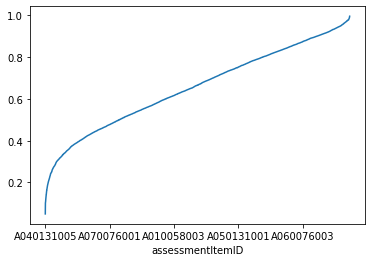

In [25]:
temp.sort_values().plot()

## 대분류별 정답률 특성 추가

- 유저의 대분류별 정답률을 나타냅니다.

In [141]:
class MakeDifficultyByFirstClass(AggFeBase):
    name = "make_difficulty_by_firstclass"
    description = {
        "firstClassDifficulty" : "유저의 대분류별 정답률을 나타냅니다."
    }
    
    pre_fe = {"make_first_class"}
    agg_column = ["userID", "firstClass"]
    
    @classmethod
    def _transform(cls, df):
        grouped_df = temp.groupby(cls.agg_column).answerCode.mean()
        a, b = zip(*grouped_df.index)
        
        right_df = pd.DataFrame(
            {"userID": a, "firstClass": b, "firstClassDifficulty": list(grouped_df)}
        )
        return right_df

In [143]:
MakeDifficultyByFirstClass.transform(temp, is_train=True)

save features dataframe to /home/j-gunmo/features/train_make_difficulty_by_firstclass.pkl ...


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,firstClass,firstClassDifficulty
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,0.791908
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,0.791908
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,0.791908
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,0.791908
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,0.791908
...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,0.200000
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4,1.000000
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4,1.000000
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4,1.000000


## 지금까지 풀어온 대분류별 정답률 특성 추가

- 유저가 푸는 문제의 대분류의 현재까지의 정답률을 나타냅니다.
- 처음 정답률은 0.5로 설정

In [86]:
class MakeSeqDifficultyByFirstClass(SeqFeBase):
    name = "make_difficulty_by_cur_firstclass"
    description = {
        "CurFirstClassDifficulty" : "유저가 지금까지 풀어왔던 문제의 대분류의 정답률을 나타냅니다"
    }
    pre_fe = {"make_first_class"}
    
    count = defaultdictt(int)
    
    def _make_row
    
    @classmethod
    def _transform(cls, df):
        new_df = pd.DataFrame()
        new_df = 
        return new_df

SyntaxError: invalid syntax (<ipython-input-86-d910daa670e4>, line 11)

In [155]:
%%time

for i, row in temp.iterrows():
    pass

CPU times: user 1min 35s, sys: 91.3 ms, total: 1min 35s
Wall time: 1min 35s


In [150]:
grouped_df = temp.groupby(["userID", "firstClass"]).answerCode.apply(lambda x: x.rolling(window=2).mean())

In [151]:
grouped_df

0          NaN
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
2266581    0.0
2266582    NaN
2266583    1.0
2266584    1.0
2266585    1.0
Name: answerCode, Length: 2266586, dtype: float64

In [131]:
a, b = zip(*grouped_df.index)

In [134]:
len(a), len(b)

(17752, 17752)

In [130]:
pd.DataFrame(zip(*grouped_df.index)).T

,0,1
0,0,2
1,0,6
2,0,8
3,1,4
4,1,9
...,...,...
17747,7438,8
17748,7440,3
17749,7440,5
17750,7441,3


In [121]:
len(list(right_df))

17752

In [122]:
right_df

userID  firstClass
0       2             0.722222
        6             0.791908
        8             0.468320
1       4             0.822719
        9             0.903409
                        ...   
7438    8             0.666667
7440    3             0.400000
        5             0.400000
7441    3             0.200000
        4             1.000000
Length: 17752, dtype: float64

In [119]:
len(train_dataset)

2266586